<a href="https://colab.research.google.com/github/MachuEngine/python-bigdata-colab-practice/blob/main/%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%9D%98%EB%A3%8C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%9C%EA%B3%B5_%EC%84%9C%EB%B9%84%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료 데이터 제공 서비스

In [1]:
# 설치 라이브러리
!pip install -U gdown
!apt-get -qq install -y fonts-nanum
!rm -rf ~/.cache/matplotlib

# matplotlib에 한글 폰트 반영
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
import shutil

# matplotlib 캐시 삭제
shutil.rmtree(mpl.get_cachedir(), ignore_errors=True)

# 설치된 한글 폰트 목록 확인 및 등록
font_list = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
for font in font_list:
    fm.fontManager.addfont(font)

# 기본 폰트 설정
mpl.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 음수 깨짐 방지


Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


Downloading...
From: https://drive.google.com/uc?id=14l-2etuL6Ow7j8g5uOJt22XIwlPlUZDy
To: /content/Seoul_ER_Info.xlsx
100%|██████████| 16.7k/16.7k [00:00<00:00, 30.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OWiTqDFKNzKBPZ5yVBCA0_Q17U0NTKgc
To: /content/seoul_geo.json
100%|██████████| 57.7k/57.7k [00:00<00:00, 55.2MB/s]


병상 종류 선택:
1. 응급실일반
2. 수술실
3. 신경과중환자실
4. 흉부외과중환자실
5. 신생아중환자실
6. 일반중환자실
7. 입원실일반
번호를 입력하세요 (예: 1): 1

병원 목록을 확인할 자치구명 입력 (예: 강남구): 강남구


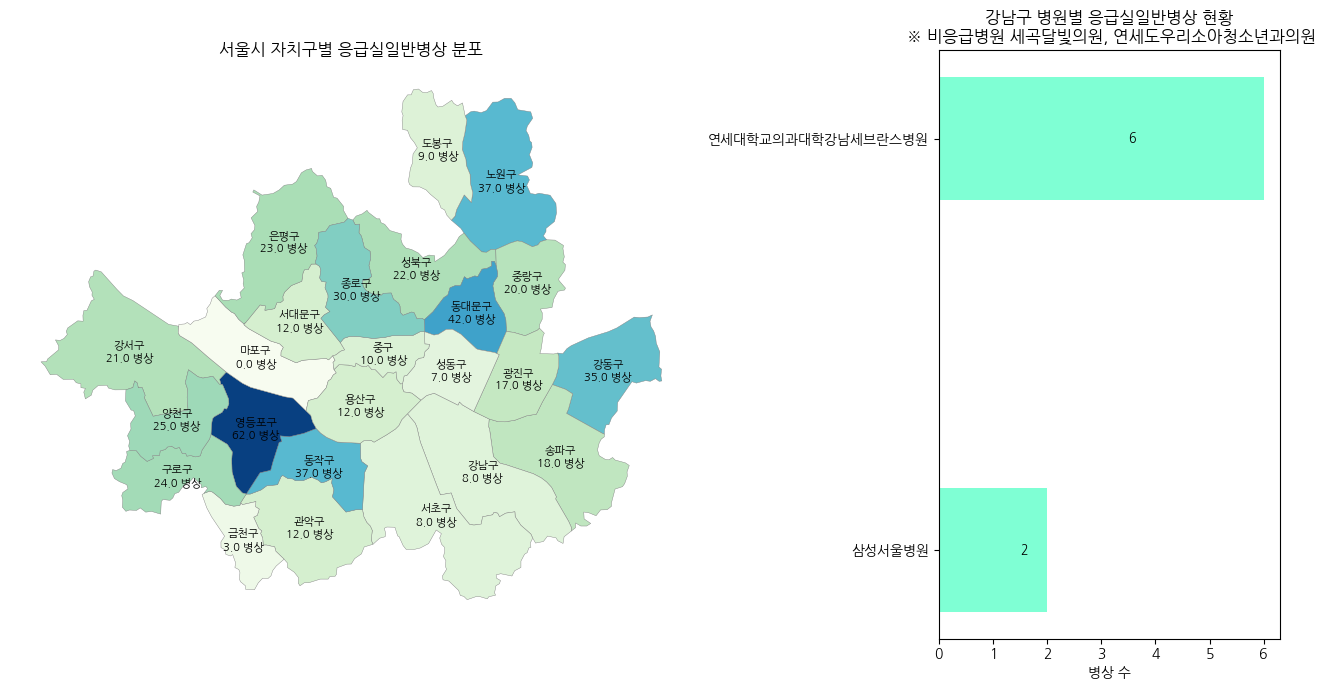

In [2]:
import gdown
from google.colab import drive
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

file_id1 = '14l-2etuL6Ow7j8g5uOJt22XIwlPlUZDy'
output = 'Seoul_ER_Info.xlsx'
gdown.download(f'https://drive.google.com/uc?id={file_id1}', output, quiet=False)

# 병상 데이터 불러오기
df = pd.read_excel(output)
bed_columns = ['응급실일반병상', '수술실병상', '신경과중환자실병상',
               '흉부외과중환자실병상', '신생아중환자실병상', '일반중환자실병상', '입원실일반병상']

# json
file_id2 = '1OWiTqDFKNzKBPZ5yVBCA0_Q17U0NTKgc'
geojson = 'seoul_geo.json'
gdown.download(f'https://drive.google.com/uc?id={file_id2}', geojson, quiet=False)


# GeoJSON 파일 불러오기, 지도그래프를 작성하기 위해 필요(geopandas)
gdf = gpd.read_file(geojson) # github에서 서울시 지도 json 파일을 사전 다운
gdf = gdf.rename(columns={"name": "자치구"}) # json 파일 내 자치구가 name으로 칼럼명 지정되어 있어 매핑을 위해 변경

# 사용자 입력: 병상 종류 선택
print("병상 종류 선택:")
for i, col in enumerate(bed_columns): # enumerate로 숫자와 병상명을 둘다 반환
    print("{}. {}".format((i+1),col[:-2])) # 0~인 i에 +1로 번호 지정, 병상명에서 병상이란 단어는 제외
sel_index = int(input("번호를 입력하세요 (예: 1): "))-1 # 위에 i+1로 출력해놨기 때문에 고르면 다시 -1 해서 번호 맞춤
sel_column = bed_columns[sel_index]


# 자치구 입력  ###### 막대그래프를 위해 추가
target_gu = input("\n병원 목록을 확인할 자치구명 입력 (예: 강남구): ")

# 병상별 자치구 집계
df_beds = df.groupby('자치구')[[sel_column]].sum().reset_index()
# 위에 선택한 병상 칼럼(sel_column)에 대한 자치구별(groupby) 합(sum)으로 재정렬(reset_index)

# 병합
view = gdf.merge(df_beds, on="자치구", how="inner")
# on(자치구)를 기준으로 두 데이터를 병합한다(병상데이터와 geojson 데이터)
# how : 조인방식으로 inner, outer, left, right 있음(교집합, 합집합 부분집합으로 보면 됨)
# how default : inner

# 한글 폰트 설정
font_name = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', size=10).get_name()
plt.rc('font', family=font_name)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(13, 7), gridspec_kw={'width_ratios': [2, 1]}) # 막대그래프 추가를 위해 서브플롯 나눔
view.plot(column=sel_column, # 위에서 선택한 병상([번호])
            cmap='GnBu', # 붉은 계열을 지양하고 파란계열로, 붉은계열은 눈이 아픔
            linewidth=0.3, # 경계선을 얇게 변경,두꺼우면 글씨랑 겹침
            edgecolor='gray', # 마찬가지로 black처럼 진한 색상은 글씨와 겹침
            ax=axes[0])
# 플롯(plot)은 figure와 axes로 구성
# plt.Figure : 축, 그래픽, 텍스트, 레이블 등 모든 객체를 포함하는 컨테이너, 그림 그자체
# plt.Axes : 축, 눈금, 레이블, 제목 등의 요소들이 모인 그래프(axis와 다름)
# 마지막에 ax=ax 작성하지 않을 경우 그래프 그려지지 않음

axes[0].set_title(f"서울시 자치구별 {sel_column} 분포") # 시각화 그래프 제목
axes[0].axis('off')


# 자치구명 + 병상 수 표시
for idx, row in view.iterrows(): # 결과물의 인덱스와 데이터를 반복
    cent = row['geometry'].centroid # geojson 파일에는 자치구별 'geometry'라는 칼럼명의 좌표값을 둠, centroid는 여기 중심값을 반환
    text = "{}\n{} 병상".format(row['자치구'],row[sel_column])
    axes[0].text(cent.x, cent.y, text,
            ha='center', va='center', fontsize=8, color='black')



######################자치구별 병상수를 옆에 막대그래프로 추가해보기###########################

# 선택 자치구 필터링
df_target = df[df['자치구'] == target_gu][['병원명', sel_column,'달빛어린이병원','서울형긴급치료센터']].copy()
# 비응급병원 추출을 위해 달빛, 서울형긴급 데이터 추가 카피(0609)


df_target = df_target.sort_values(by=sel_column, ascending=False)

# 비응급 병원 추출(0609)
moon = df_target[df_target['달빛어린이병원'] == 'Y']['병원명'].tolist()
emer = df_target[df_target['서울형긴급치료센터'] == 'Y']['병원명'].tolist()
# 비응급병원들(Y인 값)들을 반환한다


# 병원명 합치기(0609)
non_emer = moon + emer # 달빛과 서울형긴급치료센터 Y값들을 합쳐준다

if non_emer:
    title_line = ", ".join(non_emer) # 값들을 ,를 기준으로 하나로 합쳐준다
else:
    title_line = "없음" # 값이 없을경우 없음으로 출력



# 막대그래프 시각화
#plt.figure(figsize=(6, 3)) # 병원별 병상은 옵션이기 때문에 그래프 크기 작게
bars = axes[1].barh(df_target['병원명'], df_target[sel_column], color='aquamarine', height=0.3) # 지도그래프와 유사한 색감
axes[1].invert_yaxis() #### 내림차순 변경
axes[1].set_xlabel("병상 수") # x축

axes[1].set_title("{} 병원별 {} 현황\n ※ 비응급병원 {}".format(target_gu,sel_column,title_line)) #추가 그래프 제목
# 위에서 만들어 놓은 비응급병원값을 가져와서 병원 현황 아래에 출력하도록 추가(0609)


for bar in bars:
    width = bar.get_width()
    width_val = int(width) if not pd.isna(width) else 0
    axes[1].text(width/2 + 0.5, bar.get_y() + bar.get_height() / 2,
                  f'{width_val}', va='center', fontsize=9, color='black') #막대별 값 추가


plt.tight_layout()
plt.show()